In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**In this notebook, I will be using the example data from the Max Planck Institute for Biogeochemistry. The dataset is called the Jena Climate dataset. It contains measurements like temperature, humidity, and more, recorded every 10 minutes. there is a dataset with measures on weather data, and I try to predict the temperature 12 hours (72-time steps of 10 minutes) into the future.We will use only the temperature data and not the other variables. This may make the task slightly harder to accomplish. Note that it is possible to add other explanatory variables into an RNN. For forecasting tomorrow’s temperature, you may want to use not only today’s temperature but also today’s wind direction, wind speed, and humidity, for example. In this case, you could add a third dimension to the input data.**

**Reference : Advanced Forecasting with Python: With State-of-the-Art-Models Including LSTMs, Facebook’s Prophet, and Amazon’s DeepAR, Joos Korstanje, 2021**

##**1.Import libraries**

In [ ]:
import keras
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


from zipfile import ZipFile
import os

with ZipFile('/content/drive/MyDrive/Colab Notebooks/notebook 6 (RNN_GRU_LSTM_GAN)/RNN-LSTM- Data/Copy of jena_climate_2009_2016.zip','r') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/Colab Notebooks/notebook 6 (RNN_GRU_LSTM_GAN)/RNN-LSTM- Data')



##**2. Import data.**

In [ ]:
csv_path = "/content/drive/MyDrive/Colab Notebooks/notebook 6 (RNN_GRU_LSTM_GAN)/RNN-LSTM- Data/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path)

##**3. Keeping only the temperature data.**

In [ ]:
df = df[['T (degC)']]

##**4. appling the min-max scaler.**

In [ ]:

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = ['T'])

## **5. Data preperation and converting the list of lists to numpy array.**
It is also needed to split the data into a shape in which we have sequences of past data and sequences of future data. We want to predict 72 steps into the future, and we’ll use 3*72 steps into the past. This is an arbitrary choice.

In [ ]:
# Sequence Maker
ylist = list(df['T'])

n_future = 72
n_past = 3*72
total_period = 4*72

idx_end = len(ylist)
idx_start = idx_end - total_period

X_new = []
y_new = []
while idx_start > 0:
  x_line = ylist[idx_start:idx_start+n_past]
  y_line = ylist[idx_start+n_past:idx_start+total_period]

  X_new.append(x_line)
  y_new.append(y_line)

  idx_start = idx_start - 1



X_new = np.array(X_new)
y_new = np.array(y_new)

In [ ]:
print(X_new.shape)
print(y_new.shape)

(420263, 216)
(420263, 72)


##**6. train test split.**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.10, random_state=42)

In [ ]:
X_train.shape

(378236, 216)

##**7. It takes a long time to run this model. The batch size of 2000 is provided for demonstration purposes.**

In [ ]:
batch_size = 2000

n_samples = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_steps = y_train.shape[1]
n_features = 1

X_train_rs = X_train.reshape(n_samples, n_timesteps, n_features )

X_test_rs = X_test.reshape(X_test.shape[0], n_timesteps, n_features )

##**8. Parameterize a small network with SimpleRNN.**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 216, 8)            80        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 216, 8)            136       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 72)                648       
                                                                 
Total params: 1000 (3.91 KB)
Trainable params: 1000 (3.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
152/152 [==============================] - 88s 565ms/step - loss: 0.0759 - mean_absolute_error: 0.0759 - val_loss: 0.0464 - val_mean_absolute_er

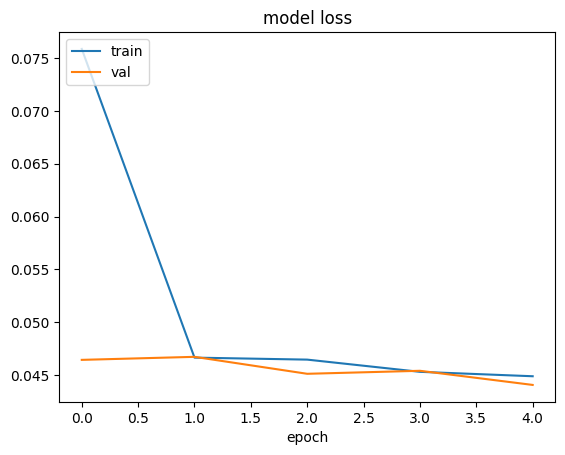

In [ ]:
random.seed(42)

simple_model = Sequential([
  SimpleRNN(8, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
  SimpleRNN(8, activation='tanh', return_sequences = True),
  SimpleRNN(8, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)



plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.6687026032024362


##**9. A simple architecture with 1 Gated Recurrent Unit (GRU) layer.**

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 72)                648       
                                                                 
Total params: 912
Trainable params: 912
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
152/152 [==============================] - 37s 233ms/step - loss: 0.0584 - mean_absolute_error: 0.0584 - val_loss: 0.0404 - val_mean_absolute_error: 0.0404
Epoch 2/5
152/152 [==============================] - 34s 226ms/step - loss: 0.0312 - mean_absolute_error: 0.0312 - val_loss: 0.0287 - val_mean_absolute_error: 0.0287
Epoch 3/5
152/152 [==============================] - 35s 233ms/step - loss: 0.0292 - mean_absolute_error: 0.0292 - val_l

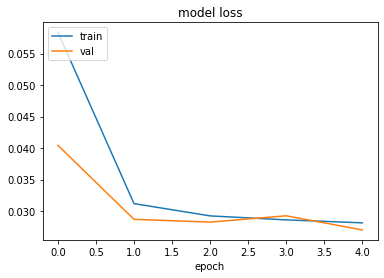

In [ ]:
random.seed(42)
from tensorflow.keras.layers import GRU

simple_model = Sequential([
   GRU(8, activation='tanh',input_shape=(n_timesteps, n_features)),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)



plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.9223744683778516


##**10. A  more complex network with three layers of Gated Recurrent Unit (GRU).**

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 216, 10)           390       
                                                                 
 gru_2 (GRU)                 (None, 216, 10)           660       
                                                                 
 gru_3 (GRU)                 (None, 10)                660       
                                                                 
 dense_2 (Dense)             (None, 72)                792       
                                                                 
Total params: 2,502
Trainable params: 2,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
152/152 [==============================] - 162s 1s/step - loss: 0.1863 - mean_absolute_error: 0.1863 - val_loss: 0.0514 - val_mean_absolute_error: 0.0514
Epoch 2/5
152/152 [=

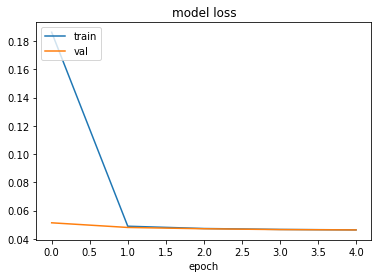

In [ ]:
random.seed(42)

simple_model = Sequential([
   GRU(10, activation='tanh',input_shape=(n_timesteps, n_features), return_sequences=True),
    GRU(10, activation='tanh', return_sequences=True),
    GRU(10, activation='tanh'),
  Dense(y_train.shape[1]),
])

simple_model.summary()

simple_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss='mean_absolute_error',
  metrics=['mean_absolute_error'],
)

smod_history = simple_model.fit(X_train_rs, y_train,
          validation_split=0.2,
          epochs=5,
          batch_size=batch_size,
          shuffle = True
)

preds = simple_model.predict(X_test_rs)



plt.plot(smod_history.history['loss'])
plt.plot(smod_history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
print(r2_score(preds, y_test))

0.657914827100534
